<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/GEOG761_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The primary objective of this lab is to familiarise you with the basic mechanics that allow you to get hold of satellite data for the purposes of carrying out machine learning. The second objective is for you to put into practice some of the theory that we covered in lecture 1, in order that you can start to understand some of the specific quirks and potentially powerful attributes of satellite data when it comes to applying machine learning techniques.

This lab has drawn upon the following sources, tutorials and repos:


*   https://geemap.org/
*   https://developers.google.com/earth-engine

Whenever you see a numbered question, e.g. '(1)', make sure that you answer it in the answer proforma and submit the resulting document on Canvas. Only submit in .docx or .pdf formats (we cannot open 'pages' etc docs on Canvas).

Some of the questions will be relatively simple and are designed to get you thinking about the nature of the code and what it is doing, whilst also requiring you to pull in theoretical knowledge from the lectures. Other questions are exercises that ask you to both apply this knowledege to a new challenge and/or require you to independently go and seek answers.

In all cases I encourage you to give it a go, even if you do not have the full answer. Particularly for the larger challenges ('Exercises'), marks are awarded for workings and I want to see your thought process in action via the code you write.

Use text comments as demonstrated in these lab instructions to explain your thinking and communicate with the person marking your work.

I use both comments above chunks of code to tell you the overall objectives of that code, and inline comments to highlight specific features and elements to be aware of (formatted like this to draw your attention '#<-').

# Set up

In [1]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1')

In [ ]:
# Install the geemap package (only needs to be run once, uncomment below and run it the first time you run this notebook in a session).
# !pip install geemap

In [2]:
import geemap

# Loading a map and displaying satellite data

In [ ]:
# Use the built in functions to load an ipyleaflet basemap (aka a UI to explore and see what we are doing)
Map = geemap.Map(center=(-41, 172), zoom=4)
Map

Map(center=[-41, 172], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [ ]:
# Specify a different kind of basemap to display data layers over
Map = geemap.Map(center=(-41, 172), zoom=4) #<- note the lat-lon coordinate pair here
Map.add_basemap("HYBRID")
Map

Map(center=[-41, 172], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

(1) Find and add the basemap 'OpenTopoMap' to the display window AND change the code so that the map opens and zooms to the city of Auckland.
Provide a screenshot of your code and the output. (2 pts)

In [ ]:
# Specify a different kind of basemap to display data layers over
Map = geemap.Map(center=(-36.9, 174.9), zoom=12) #<- note the lat-lon coordinate pair here
Map.add_basemap("OpenTopoMap")
Map

Map(center=[-36.9, 174.9], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# Add Earth Engine datasets to our map by first creating variables to hold the calls to the EE api
Map = geemap.Map(center=(-41, 172), zoom=4)
dem = ee.Image("USGS/SRTMGL1_003")
landcover = ee.Image("ESA/GLOBCOVER_L4_200901_200912_V2_3").select("landcover")
landsat7 = ee.Image("LANDSAT/LE7_TOA_5YEAR/1999_2003")
states = ee.FeatureCollection("TIGER/2018/States")

In [ ]:
# Set visualization parameters.
vis_params = {
    "min": 0,
    "max": 4000, #<- if your satellite image is all white or all black, these vis params are the first thing to check and change
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"], #<- these are HTML colour codes
}

In [ ]:
# Add a variety of different Earth Engine layers to the Map object
Map.addLayer(dem, vis_params, "SRTM DEM", True, 0.5) #<- note vis params called from the dictionary we set up before
Map.addLayer(landcover, {}, "Land cover")
Map.addLayer(
    landsat7, {"bands": ["B3", "B2", "B1"], "min": 20, "max": 200, "gamma": 3}, "Landsat 7" #<- note vis params in a dictionary here inside the add layer call
)
Map.addLayer(states, {}, "US States")

In [ ]:
# Dump all of this into the map view and take a look...
Map

Map(bottom=21231.0, center=[-44.61393394730627, 170.93627929687503], controls=(WidgetControl(options=['positio…

(2) The Landsat 7 data displays as red colored/tinged image. Why is this? [Think about both the content in Lecture 1, and what is going on when you visualize a satellite image]. (2 pts)

(3) Correct the display of the Landsat 7 image so that it displays in '[True Colour](https://ie.unc.edu/wp-content/uploads/sites/277/2014/12/How-Satellite-images-are-different-from-photographs.pdf)'. Provide a screenshot of your code and the corrected output over the whole of New Zealand. (10 pts)

# Spectral reflectance curves
Next we we will generate a spectral reflectance curve for a given area.
This is a useful tool when you are considering if a given target has spectral characteristics for identification in ML. If everything has the same spectral signature, then you need to take a different approach to a simple spectral classification, as might have been the first instinct of a classical remote sensing scientist.

In [ ]:
# Add in a library for plotting the data we extract
import matplotlib.pyplot as plt

In [ ]:
# Define a point and a small rectangular region around it
point = ee.Geometry.Point([174.7633, -36.8485])  # Auckland, NZ
region = point.buffer(150).bounds()  # ~300 m box

In [ ]:
# Load a Landsat 7 Collection 2 Level 2 SR image (surface reflectance)
image = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2002-01-01', '2002-12-31') \
    .sort('CLOUD_COVER') \
    .first()

(4) Why are we using the surface reflectance (SR) here rather than the top of atmosphere (ToA)? (2 pt)

In [ ]:
# Select surface reflectance bands and apply scale factor
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
band_names = {
    'SR_B1': 'Blue (0.45–0.52 μm)',
    'SR_B2': 'Green (0.52–0.60 μm)',
    'SR_B3': 'Red (0.63–0.69 μm)',
    'SR_B4': 'NIR (0.77–0.90 μm)',
    'SR_B5': 'SWIR1 (1.55–1.75 μm)',
    'SR_B7': 'SWIR2 (2.09–2.35 μm)'
}

scale_factor = 2.75e-5  # From USGS documentation for Landsat C2 L2

(5) What is a 'scale factor' as has been used in the prior code cell, and why are they used in satellite data storage-to-processing workflows such as this? (2 pts)

**Important sidenote**

The 'reduce' operation is a key concept in the backend of how Google is storing and serving us large quanities of satellite data. GEE uses 'reducers' in multiple ways, many of which are not always immediately intuitive. Check out the docs for more information:

*   https://developers.google.com/earth-engine/guides/reducers_intro

Here we are using a reduce operation over the specified small sample area in order to find the mean of all the cells that lie within the region:

**Not from myself and Gemini:**

In your code, ee.Reducer.mean() tells Google Earth Engine (GEE):
"Look at all the pixels inside the specified region, and for each band, calculate the average value. Give me back just that one average number."

This is incredibly powerful and efficient. Instead of downloading thousands of data points to your computer to calculate the mean yourself, the calculation is done on Google's servers, and only the single result (the mean) is sent back to you.

In [ ]:
# Reduce region to mean reflectance
mean_dict = image.select(bands).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=30,
    maxPixels=1e6
)

mean_dict.getInfo()

{'SR_B1': 9652.664958006388,
 'SR_B2': 9925.442569299315,
 'SR_B3': 10043.854855881073,
 'SR_B4': 10288.878001656085,
 'SR_B5': 10381.604077126296,
 'SR_B7': 9926.202633965539}

**Note from myself and Gemini:** You use the average (a reduce operation) when you care about the overall state of a region. For example, the average that you would get out of this reduce operation could serve as a comparison value to track NDVI of the region over time (low NDVI when planting, high when plants have grown, low again after harvest).

You would do pixel-based analysis (like object detection) when you care about finding specific things within that region.

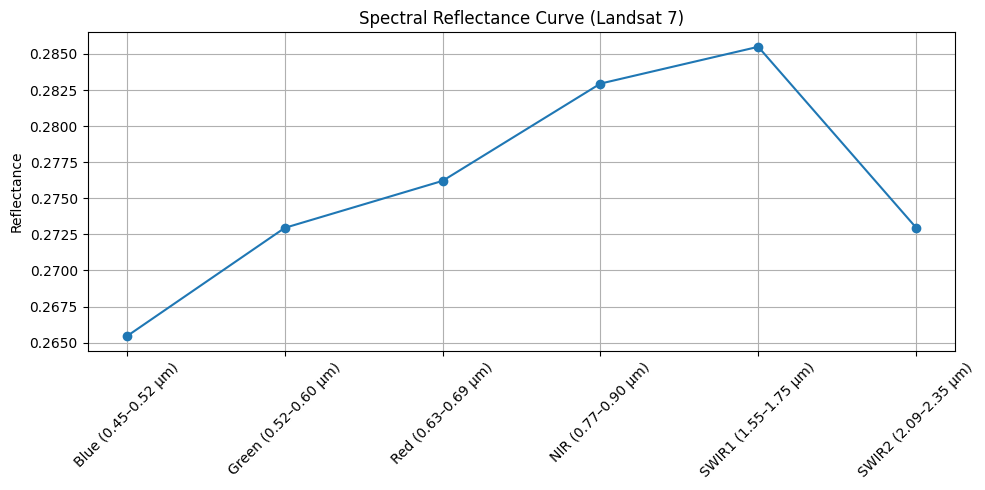

In [ ]:
# Extract and scale values
mean_values = mean_dict.getInfo()
reflectance = [mean_values[b] * scale_factor for b in bands]

# Plot the spectral curve
plt.figure(figsize=(10, 5))
plt.plot(list(band_names.values()), reflectance, marker='o', linestyle='-')
plt.title('Spectral Reflectance Curve (Landsat 7)')
plt.ylabel('Reflectance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

(6) If we want to apply multiple reducers to the same inputs what is a more efficient way to do so than just writing out a long series of sequential reducers on our end? (2 pts)

# Cloud cover
A final consideration that I want to cover in this lab is that of cloud cover. Cloud cover removal is a complex and often difficut process that GISCI 341 students spend an entire two weeks tackling as a focus (so use them in your teams!). However, for our purpose here lets just use the basic in-built cloud clearing native to the Landsat 7 collection on GEE.

In [ ]:
# Define small region around Auckland, NZ
point = ee.Geometry.Point([174.7633, -36.8485])
region = point.buffer(500).bounds()


# Load the image with least cloud cover in 2002
image = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
    .filterBounds(region) \
    .filterDate("2002-01-01", "2002-12-31") \
    .sort("CLOUD_COVER") \
    .first() #<- note the filtering step that is being applied here! We are taking the first image in a sorted by cloud cover response.

# Check metadata
print('Image ID:', image.get('LANDSAT_PRODUCT_ID').getInfo())
print('Cloud Cover (whole scene):', image.get('CLOUD_COVER').getInfo())

Image ID: LE07_L2SP_073086_20020827_20200916_02_T1
Cloud Cover (whole scene): 1


In [ ]:
# Function to mask clouds using QA_PIXEL band
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    # Bits 3 and 4 are cloud and cloud shadow respectively
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(
                 qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(cloud_mask)

# Apply mask
masked_image = mask_clouds(image)

**Important side note**

In the function above we are using a bitwise operation in order to search through the quality assurance (QA) band of the image. Different satellites have different bit-masks. Read more about bitmasks and how they are used here:
*   https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/



**Another important side note**

You will have noticed that we are frequently running code and not seeing anything happen in terms of output in the cell or changes in the RAM/Disk of the Colab instance (check the small graphs top right). This is deliberate! Satellite data is large and hard to wrangle. GEE does a lot of the work for us, hence we can explore and get into it so quickly. Part of how it does this is by not executing any of your API calls until you specifically ask for an output to be sent back to you. Prior to calling an output (usually through a 'AddLayer' or similar call), when using the GEE/EE API you are essentially chaining together a lot of dot-operators (e.g. '.sort \ .reduce') into a series of instructions that are verified, but only then acted on when required.

This is the result of a 'client vs. server' approach. For more detail, that will help you understand why you can and cannot do certain things, see:
*   https://developers.google.com/earth-engine/guides/client_server



In [ ]:
# Report Image Quality Over ROI
# Total pixels in region
pixel_area = ee.Image.pixelArea().clip(region)

# Count valid pixels before and after masking
total_pixels = pixel_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=30,
    maxPixels=1e9
).getInfo()['area']

valid_pixels = masked_image.select('SR_B3').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=30,
    maxPixels=1e9
).getInfo()['SR_B3']

cloud_coverage_pct = 100 * (1 - valid_pixels / total_pixels)

print(f"Total Pixels: {total_pixels}")
print(f"Valid (non-cloud) Pixels: {valid_pixels}")
print(f"Estimated Cloud Coverage in ROI: {cloud_coverage_pct:.2f}%")

Total Pixels: 1394
Valid (non-cloud) Pixels: 1050
Estimated Cloud Coverage in ROI: 24.68%


In [ ]:
# Visualize the before and after
Map = geemap.Map(center=[-36.8485, 174.7633], zoom=12)

vis = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}

Map.addLayer(image, vis, 'Original Image (Cloudy)')
Map.addLayer(masked_image, vis, 'Cloud Masked')
Map

Map(center=[-36.8485, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

(7) Produce a table that summarises the amount of cloud cover per year (as a percentage) for 2005, 2010 and 2015 over a region of your choice. Provide a screenshot of your code that does so in addition to your table. (5 pts)

**NOTE:**

I wanted to look at Reykjavik, Iceland for this task, and had run an inital version before detecting all of the calculations errors on the  correct region in Iceland. After that, I forgot that my region was not called "region"  anymore, but "region_icelaand", and made the code work with the region around Auckland. I now raan the whole thing on the actual region in Icelaand, and I got the following output:

Year 2005 (Landsat 5): No images found in archive.

Year 2010 (Landsat 5): No images found in archive.

Year 2015 (Landsat 8): Calculation failed, likely no unmasked pixels.

I believe that the coverage over Iceland is just terrible or whatever, may be worthing looking into if I want to. But for now, I just left it on the region around Auckland aand will siply deliver a more sophisticated code than expected, I guess.

In [ ]:
# Define small region around Reykjavik, Iceland
point_iceland = ee.Geometry.Point([-21.9426, 64.1466])
region_iceland = point_iceland.buffer(500).bounds()

years = [2005, 2010, 2015]
results_list = []

# Loop through each year
for year in years:
  start_date = f'{year}-01-01'
  end_date = f'{year}-12-31'

  # When I was only working with Landsat 7, I was always getting errors related to the dictionary,
  # and I thought that this might come from the fact that the data was empty and the dictionary
  # cannot perform any caluclations with empty/non-existent data.
  # So I figured that Landsat 7 might not have coverage for one of the years over my area.
  # I googled the best Landsat verssions for the years 2005, 2010 and 2015 and decided to use Landsat 5 and 8

  # Select the best Landsat satellite and bands for the given year
  if year < 2013:
      collection_name = "LANDSAT/LT05/C02/T1_L2"  # Landsat 5
      band_name = 'SR_B3'
  else:
      collection_name = "LANDSAT/LC08/C02/T1_L2"  # Landsat 8
      band_name = 'SR_B4'

  # Get the image collection
  collection = ee.ImageCollection(collection_name) \
      .filterBounds(region) \
      .filterDate(start_date, end_date)

  # First, check if there are any images in the collection for that year to avoid the kinds of errors that I was getting earlier
  if collection.size().getInfo() > 0:
      # If images exist, proceed with the calculation
      def calculate_cloud_frequency(coll):
          total_observations = coll.select(band_name).count()
          clear_observations = coll.map(mask_clouds).select(band_name).count()
          # I wanted to make the next step very simple, but apparently I cannot cannot use
          # the standard mathematical operators like - and / for image calculations in the Google Earth Engine Python API.
          # But luckily the EE API provides specific mathemathicaal functions, so here we go
          cloud_frequency = total_observations.subtract(clear_observations) \
                                  .divide(total_observations.max(ee.Image(1)))
          return cloud_frequency

      # Here, I create a single image representing cloud frequency, where each pixel's value represents
      # the frequency or proportion of time that specific pixel was covered by clouds throughout the entire year
      cloud_frequency_image = calculate_cloud_frequency(collection)

      # calculating the average cloud frequency
      mean_cloud_frequency = cloud_frequency_image.reduceRegion(
          reducer=ee.Reducer.mean(),
          geometry=region,
          scale=30,
          maxPixels=1e9
      )

      # Getting the result from the server and print it
      # Note: The output band is named after the input band, so I use also use band_name for the output
      mean_cloud_info = mean_cloud_frequency.getInfo()
      if band_name in mean_cloud_info and mean_cloud_info[band_name] is not None:
          cloud_percentage = mean_cloud_info[band_name]

          # Here I print collection_name[11] because the 11th character in the name is the number of the landsat version
          print(f"Year {year} (Landsat {collection_name[11]}): {cloud_percentage * 100:.2f}% average cloud cover over Auckland")
          results_list.append({'Year': year, 'Satellite': collection_name[11], 'Cloud Cover (%)': f"{cloud_percentage:.2f}"})
      else:
          print(f"Year {year} (Landsat {collection_name[11]}): Calculation failed, likely no unmasked pixels.")
  else:
      # If no images were found, I print this message and continue to the next year
      print(f"Year {year} (Landsat {collection_name[11]}): No images found in archive.")


Year 2005 (Landsat 5): 55.21% average cloud cover over Auckland
Year 2010 (Landsat 5): 64.75% average cloud cover over Auckland
Year 2015 (Landsat 8): 68.07% average cloud cover over Auckland


In [ ]:
import pandas as pd
# Creating a pandas DataFrame from the list of results
df = pd.DataFrame(results_list)
print("\n--- Cloud Cover Comparison ---")
# Using .to_string() ensures the table formatting is clean
print(df.to_string(index=False))


--- Cloud Cover Comparison ---
 Year Satellite Cloud Cover (%)
 2005         5            0.55
 2010         5            0.65
 2015         8            0.68


# Final exercise
Let us now be very fancy and plot our spectral reflectance curve along with a display of the satellite data that it was generated from. As well as being fancy, this lets us see that what we have done here is sample the urban fabric of downtown Auckland and collect the spectral signature of 'urban'.

The code block below is large and calls in some further packages as we start to push beyond what is already built into geemap. I have also placed all the required code in one cell as I am about to ask you to do something with it... Make sure that you take the time understand what each section is doing and why. Consider starting to break this code down into functions that you can re-use later.

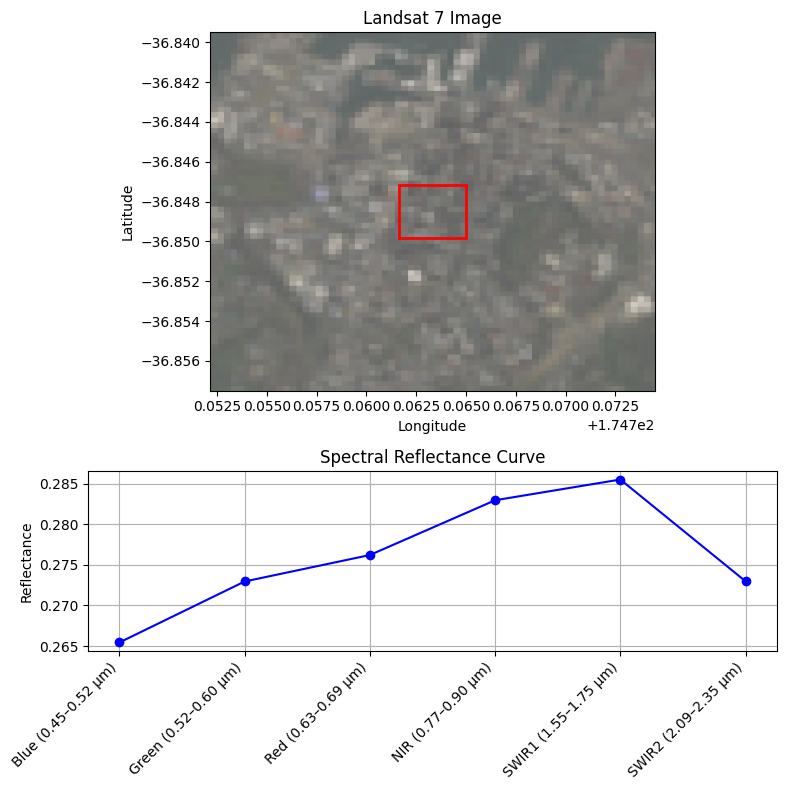

In [ ]:
# Additional required packages
import matplotlib.patches as patches
import urllib.request
import tempfile
import matplotlib.image as mpimg

# Define point and regions
point = ee.Geometry.Point([174.7633, -36.8485])
region = point.buffer(150).bounds()        # ~300 m box
expanded_region = point.buffer(1000).bounds()  # box for image preview

# Load Landsat 7 surface reflectance image
image = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterBounds(region) \
    .filterDate('2002-01-01', '2002-12-31') \
    .sort('CLOUD_COVER') \
    .first()

# Define bands and scaling
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
band_names = {
    'SR_B1': 'Blue (0.45–0.52 μm)',
    'SR_B2': 'Green (0.52–0.60 μm)',
    'SR_B3': 'Red (0.63–0.69 μm)',
    'SR_B4': 'NIR (0.77–0.90 μm)',
    'SR_B5': 'SWIR1 (1.55–1.75 μm)',
    'SR_B7': 'SWIR2 (2.09–2.35 μm)'
}
scale_factor = 2.75e-5

# Calculate mean reflectance
mean_dict = image.select(bands).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=30,
    maxPixels=1e6).getInfo()

reflectance = [mean_dict[b] * scale_factor for b in bands]
labels = list(band_names.values())

# Get RGB thumbnail slightly zoomed out
thumb_params = {
    'dimensions': 512,
    'region': expanded_region,
    'format': 'png',
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0,
    'max': 30000,
    'gamma': 1.4
}
url = image.getThumbURL(thumb_params)

# Get coordinates of regions
def get_bounds_coords(bounds):
    coords = bounds.coordinates().getInfo()[0]
    lons = [pt[0] for pt in coords]
    lats = [pt[1] for pt in coords]
    return min(lons), max(lons), min(lats), max(lats)

# Extract bounding boxes
xmin, xmax, ymin, ymax = get_bounds_coords(expanded_region)
rxmin, rxmax, rymin, rymax = get_bounds_coords(region)

# Plot both panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

# Load and plot image with annotation
with tempfile.NamedTemporaryFile(suffix=".png") as f:
    urllib.request.urlretrieve(url, f.name)
    img = mpimg.imread(f.name)
    ax1.imshow(img, extent=[xmin, xmax, ymin, ymax])
    ax1.set_title("Landsat 7 Image")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    # Add red rectangle for region of interest
    width = rxmax - rxmin
    height = rymax - rymin
    rect = patches.Rectangle((rxmin, rymin), width, height,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")

# Plot reflectance
ax2.plot(labels, reflectance, marker='o', color='blue')
ax2.set_title("Spectral Reflectance Curve")
ax2.set_ylabel("Reflectance")
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()


(8) Using Sentinel 2, create a figure that does the following over the city of Christchurch, NZ:
*   Conduct a basic quality assessment of the data you use, using a cloudy pixel % estimate.
* Describe/show the spectral reflectance signatures of: urban, forest, grassland, water and bare soil.
* Illustrates the sample areas that you have used to create these spectral signatures.

Provide a publication quality copy of this figure in the answer proforma. Publication quality means that:  
1.   It is at a good quality (resolution) and not blurry.
2.   The font size of all elements is big enough to read easily on a screen when placed in the document.
3. Has a figure caption that ensures the reader knows what you have done and why.
4. Tells the story 'at a glance'. Don't make your viewer work too hard to understand your core message.

(25 pts)




In [ ]:
'''

The cloud cover quality assessment with bitmasking was causing me a lot of problems with Sentinel 2, so I decided to redo this part with the apparently way more accurate SQL band, see below.


# Quality assessment

# For the QA, I will first mask the data and then subtract the amount of cloud pixels from the amount of total pixels in my region

def mask_clouds_qa60(image):

    # I chose the band QA60 because it seems to be the Sentinel 2 equivalent to QA_PIXEL for Landsat 7
    # After researching cloud removal in Sentintel 2, it seem like bitmasking does exist for it, but something called "Cloud Score+" works apperently way better.
    # I will start by implemented bitmasking the way you showed us in this lab, and if I still have time and motivation afterwards, I'll try implementing a cloud QA using Cloud Score+.

    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus (thin clouds in very high altitude), respectively.

    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0).And(
                 qa.bitwiseAnd(1 << 11).eq(0))

    # Apply the mask to the original image
    return image.updateMask(cloud_mask)

# Apply mask
masked_image = mask_clouds_qa60(image)

# Report Image Quality Over ROI
# Total pixels in region
pixel_area = ee.Image.pixelArea().clip(region)

# Count valid pixels before and after masking
total_pixels = pixel_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=60, # Changed the scale from 30 to 60 to match the scale of the QA60 band, which is reported to be one of the big drawbacks of the qa60 band. I'll continue trying to implement it.
    maxPixels=1e9
).getInfo()['area']

valid_pixels = masked_image.select('B3').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=region,
    scale=60, # Changed the scale from 30 to 60 to match the scale of the QA60 band
    maxPixels=1e9
).getInfo()['B3']

cloud_coverage_pct = 100 * (1 - valid_pixels / total_pixels)

print(f"Total Pixels: {total_pixels}")
print(f"Valid (non-cloud) Pixels: {valid_pixels}")
print(f"Estimated Cloud Coverage in ROI: {cloud_coverage_pct:.2f}%")

'''

Total Pixels: 343686
Valid (non-cloud) Pixels: 29980
Estimated Cloud Coverage in ROI: 91.28%


Number of images in the collection: 102
Mean Cloud Cover in ROI: 57.34%
Spectral data : {'Urban': [0.07691967142857144, 0.0882810457142857, 0.09005136000000001, 0.1622860042857142, 0.1484883828571429, 0.1235112714285714], 'Forest': [0.010626236448410993, 0.015260230555793923, 0.009036424096799101, 0.17893610086100853, 0.047843267828027086, 0.020760056065676928], 'Grassland': [0.031478041988003434, 0.05740157669237361, 0.04186310625535562, 0.3280498971722365, 0.18668920736932307, 0.10132038988860331], 'Water': [0.0686700011432491, 0.06452878415456731, 0.024540958328569795, 0.00874668314850806, 0.003531988110209214, 0.0030965345261232432], 'Bare Soil': [0.05769915998855181, 0.07420495993131082, 0.0631717658843732, 0.16456939038351456, 0.11116651688609047, 0.06939178305666857]}


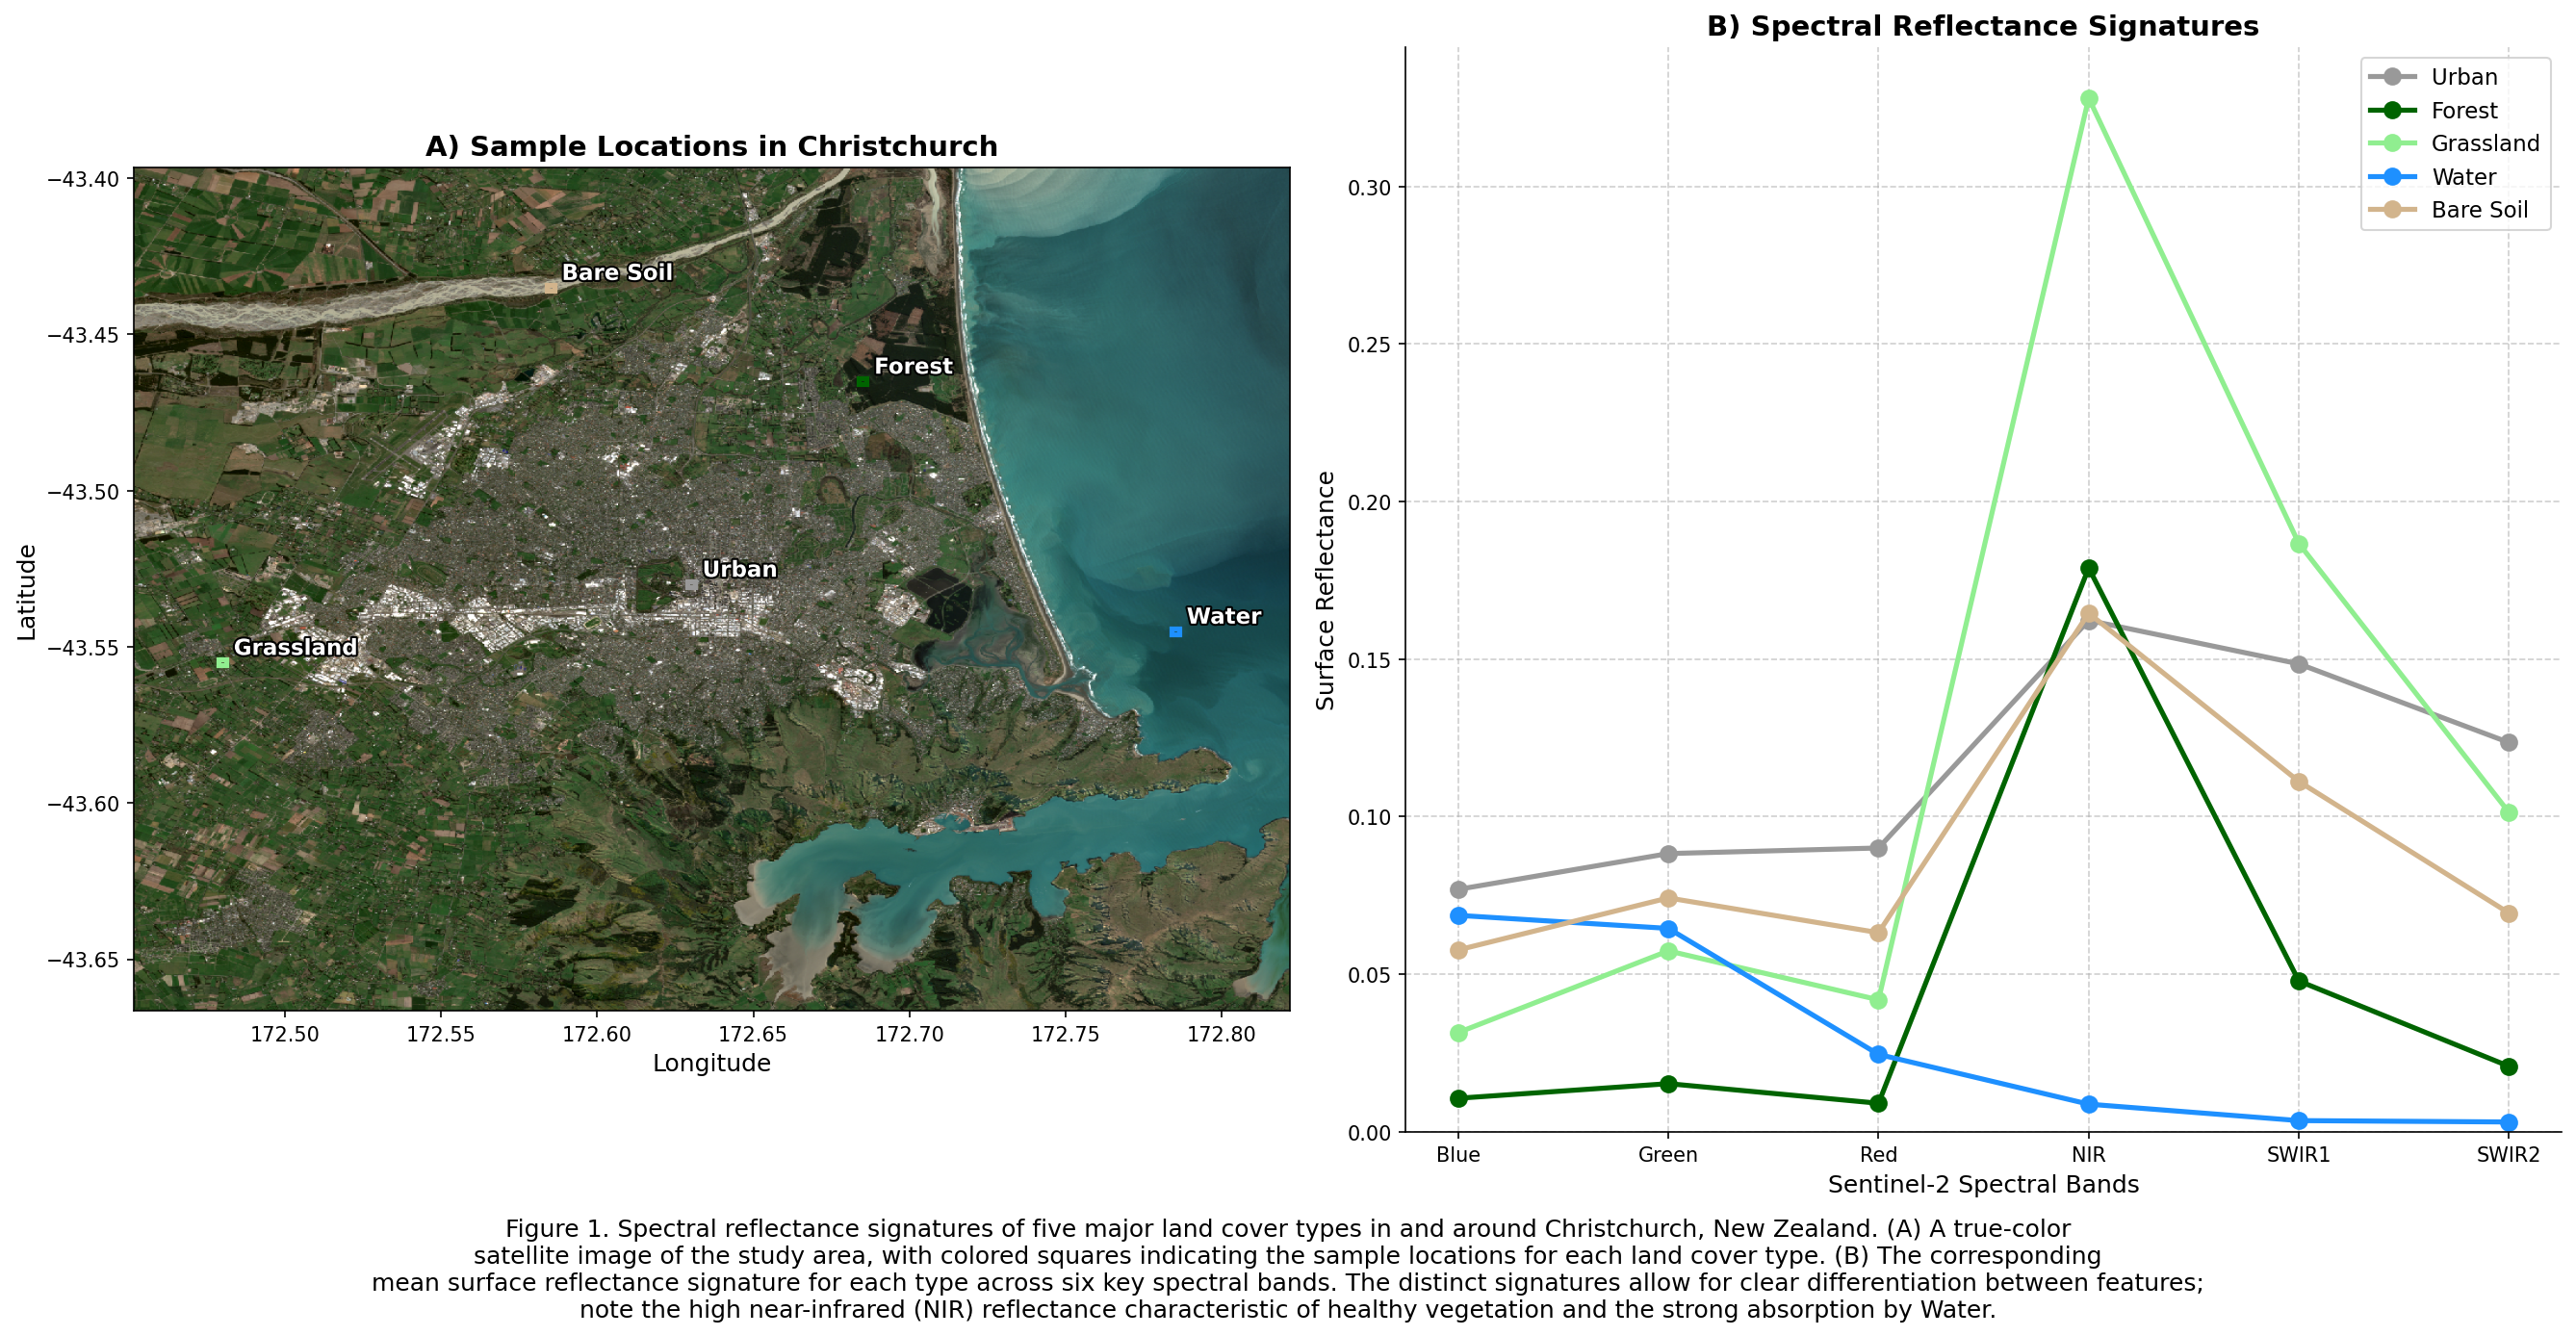

In [29]:
import ee
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import urllib.request
import tempfile
import matplotlib.image as mpimg
import numpy as np
import matplotlib.patheffects as PathEffects

# Define point and regions
point = ee.Geometry.Point([172.6365, -43.5316])
region = point.buffer(15000).bounds()        # 15km

# I wanted a whole year but it did not work for whatever reason, so I chose to take only half aa year which is still a lot of data I guess
start_date = '2024-06-01'
end_date = '2025-01-01'

# Fetching all of the images for this region
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(region) \
    .filterDate(start_date, end_date)

# I wanted to see the  temporal resolution of what I was working with, just out of curiosity
# Turned out to be 102 images in 30,5 weeks, i.e. 3.3 pictures per week
print(f"Number of images in the collection: {s2_collection.size().getInfo()}")



# Quality assessment


# Masking clouds and shadows using the SCL band
def mask_scl(image):
    scl = image.select('SCL')

    # Mask out cloud shadow (3), medium (8) & high (9) probability cloud, and cirrus (10)
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))

    return image.updateMask(mask)

# Calculating the average cloud cover of the initial collection to describe the input data.
# This tells me how much cloud I had to remove
def get_cloud_cover(image):
    scl = image.select('SCL')
    # Same classes as for the mask
    cloud_pixels = scl.eq(3).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10))
    # Calculate the percentage of cloudy pixels in the region
    cloud_fraction = cloud_pixels.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=20, # 20m scale for SCL-compatible bands
        maxPixels=1e9
    ).get('SCL')
    # Returning a feature with the cloud fraction property
    # -> A Feature is a standard container for a geometry and its data so the .map() function can return my calculated number in a consistent format that the collection can process
    return ee.Feature(None, {'cloud_fraction': cloud_fraction})

# I'm using the "get_cloud_cover" function on each  of the 102 images in my collection to get the cloudcover
# and then I calculate the mean cloud cover for the whole area, per image shot
mean_cloud_fraction = s2_collection.map(get_cloud_cover).reduceColumns(
    reducer=ee.Reducer.mean(),
    selectors=['cloud_fraction']
).getInfo()['mean']

mean_cloud_cover_pct = mean_cloud_fraction * 100
print(f"Mean Cloud Cover in ROI: {mean_cloud_cover_pct:.2f}%")
# Turns out to be 57.34%



# Spectral signature extraction


# Defining sample points for different land cover types
sample_points = {
    'Urban': ee.Geometry.Point([172.630, -43.530]), # Christchurch city center
    'Forest': ee.Geometry.Point([172.685, -43.465]), # Bottle Lake Forest Park
    'Grassland': ee.Geometry.Point([172.480, -43.555]), # Some field behind the city
    'Water': ee.Geometry.Point([172.785, -43.545]), # By the coast
    'Bare Soil': ee.Geometry.Point([172.585, -43.435]) # Riverbed Waimakariri River
}

# Defining the Sentinel-2 bands like we did earlier for Landsat 7
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
band_names_short = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
# Source: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/

scale_factor = 0.0001
# Source: https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#:~:text=For%20Sentinel%2D2%20optical%20data,See%20also%20Harmonize%20Values.&text=*Higher%20values%20are%20expected%20in,can%20easily%20be%20above%201.
# It says that they multiplied the raw data with 10000, so I believe that I will have to mulitply the integer data from the data provider by 0,0001

colors = {'Urban': '#999999', 'Forest': '#006400', 'Grassland': '#90EE90', 'Water': '#1E90FF', 'Bare Soil': '#D2B48C'}


# Now, I create a cloud-free median composite image for extracting spectral data for the spectral curve
# I wanted it to be very highh quality, so I removed the clouud pixels from all of the 102 images from the 6 months
# And then I calculated the median of all of the same pixels
# I researched whether to use mean or median, and median seems to be more resilient to outliers and we don't want weird different pixels from the surroundings, so here we go
analysis_image = s2_collection.map(mask_scl).median()

# I will now extract the reflectance data
# First, I create sample area geometries:
# I loop over each single coordinate point of my areas of interest (forest, grassland etc) and turning it into a small, square area like we did for the large Christchurch area
spectral_data = {}
sample_areas = {}
for name, point in sample_points.items():
    sample_region = point.buffer(100).bounds()
    sample_areas[name] = sample_region
    # I use the high quality cloud free image here for data extraction
    mean_dict = analysis_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sample_region,
        scale=20, # 20m scale for SCL-compatible bands
        maxPixels=1e9
    ).getInfo()

    # The "or 0" handles potential None values if a specific pixel has no data, for example because it always had cloud cover so every single iage had this pixel masked
    reflectance = [(mean_dict.get(b) or 0) * scale_factor for b in bands]
    spectral_data[name] = reflectance

print(f"Spectral data : {spectral_data}")


# PLOTTING


# I want a figure that has two panels side to side to show the map with the areeas of iterest, and the other side the spectral curve.
# You said you wanted high quality images so I looked at some quality settings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), dpi=150)
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Panel 1: Map of sample areas
ax1.set_title("A) Sample Locations in Christchurch", fontsize=14, weight='bold')

# I wanted to create a simple thumbnail as you did earlier, just for the background of the map where I would be showing the areas of interest
# So I searched for the single least-cloudy image from the collection just for the map background
viz_image = s2_collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()
thumb_params = {'dimensions': 1024, 'region': region.getInfo()['coordinates'], 'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4}
url = viz_image.getThumbURL(thumb_params)

# Get bounding box for map extent so that the axes are not meaninglessly labeled from 0 to 1024 pixels
# This way, the code knows the geolocation of the image and could actually label the axes with longitude and latitude
coords = region.coordinates().getInfo()[0]
xmin, xmax = min(p[0] for p in coords), max(p[0] for p in coords)
ymin, ymax = min(p[1] for p in coords), max(p[1] for p in coords)

# Downloading and displaying the image
with tempfile.NamedTemporaryFile(suffix=".png") as f:
    urllib.request.urlretrieve(url, f.name)
    img = mpimg.imread(f.name)
    ax1.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='equal')

# Adding labeled rectangles for each sample area
for name, area in sample_areas.items():
    area_coords = area.coordinates().getInfo()[0]
    r_xmin, r_xmax = min(p[0] for p in area_coords), max(p[0] for p in area_coords)
    r_ymin, r_ymax = min(p[1] for p in area_coords), max(p[1] for p in area_coords)
    width, height = r_xmax - r_xmin, r_ymax - r_ymin
    rect = patches.Rectangle((r_xmin, r_ymin), width, height, linewidth=2.5, edgecolor=colors[name], facecolor='none')
    ax1.add_patch(rect)
    ax1.text(r_xmax, r_ymax, f' {name}', color='white', fontsize=11, weight='bold', ha='left', va='bottom',
             path_effects=[PathEffects.withStroke(linewidth=2, foreground='black')])

ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Panel 2: Spectral signatures
ax2.set_title("B) Spectral Reflectance Signatures", fontsize=14, weight='bold')
for name, data in spectral_data.items():
    ax2.plot(band_names_short, data, marker='o', linestyle='-', label=name, color=colors[name], linewidth=2.5, markersize=8)

ax2.set_xlabel("Sentinel-2 Spectral Bands", fontsize=12)
ax2.set_ylabel("Surface Reflectance", fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

caption = (
    f"Figure 1. Spectral reflectance signatures of five major land cover types in and around Christchurch, New Zealand. (A) A true-color\n"
    f"satellite image of the study area, with colored squares indicating the sample locations for each land cover type. (B) The corresponding\n"
    f"mean surface reflectance signature for each type across six key spectral bands. The distinct signatures allow for clear differentiation between features;\n"
    f"note the high near-infrared (NIR) reflectance characteristic of healthy vegetation and the strong absorption by Water."
)

fig.text(0.5, -0.02, caption, ha='center', fontsize=12, wrap=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
